# Customer Clustering and Churn Prediction in a Bank 
**Authors**: [Levi Guerra](https://github.com/LeviGuerra) and [Jaime Blanco](https://github.com/bljaime).

*Every customer lost is a loss of capital*. This idea has been the main motivation to this work, which tries to answer how can we optimally predict and prevent customer loss. We base our study on data from a bank, but the model could be easily generalized to any sort of company or institution where churn may be a concern. 

Two hypothesis are assumed in our model: 
1. *"Customers can be optimally clustered"*. Knowing the customers and their needs is essential. If we are able to classify them in different clusters, we can apply specific preventive solutions depending on the characteristics of each cluster. These solutions can be tested and optimized over time.
2. *"It is possible to predict whether a customer will leave or not"*. This will be done by means of deep learning. We expect a high accuracy.


### Table of Contents 
- 0. Loading the Dataset
- 1. Exploratory Data Analysis
    - 1.1 Visualizing the Distributions
    - 1.2 Valuable Information about Customers
    - 1.3 Correlation between the Variables
- 2. Clustering Customers
    - 2.1 Visualizing the Space of Highly Correlated Variables
    - 2.2 Finding Clusters
    - 2.3 Visualizing and Understanding Clusters
- 3. How to Handle Imbalanced Classes
- 4. Neural network models
    - 4.1 Training the model with imbalanced data
    - 4.2 Data resampling and model training with new data
- 5. Beyond accuracy metric: Receiver Operator Characteristic (ROC) Curve

## 0. Loading the Dataset

The dataset was freely obtained [here](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling). We chose it specifically for being a *fresh*, barely used dataset. It contains information (14 variables) about 10.000 customers, where 7963 of them remained (79.6%) and 2037 exited (20.4%). Both the list and type of variables, together with a preview of the dataset, are shown below.

A transformation of the original dataset is needed though. In this section we apply sequentially the following steps:

0. Load the dataset.
1. Eliminate unnecesary attributes.
2. Transformation of variable *Gender: {Male, Female}* into *IsMale: {0, 1}*.
3. Categorical data: *one-hot encoding*.
4. Normalization of numerical data.
5. Definition of X (input variables) and Y (output/target).

*Note: we will preserve a 'denormalized' dataset X for data visualization. For machine learning tasks, its normalized counterpart will be used*.

In [1]:
import numpy as np
import scipy as sc
import sklearn as sk
import pandas  as pd
import seaborn as sb
import random
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib.ticker import MaxNLocator
pd.options.mode.chained_assignment = None  # default='warn' || https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas

In [2]:
# Loading the .csv
bank_data = pd.read_csv("churn_dataset_Bank.csv")  

# Eliminating unnecesary attributes
bank_data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)  # inplace=True to perform it over the dataset itself

bank_data.rename(columns = {'Gender':'IsMale'}, inplace=True)
bank_data.IsMale.loc[bank_data.IsMale == 'Female'] = 0        # Alternative doesn't work: bank_data.IsMale.replace([0, 1], ['Female', 'Male'], inplace=True)
bank_data.IsMale.loc[bank_data.IsMale == 'Male'] = 1

# Separating numerical (to normalize) and categorical variables (one-hot encoding)
num_subset = bank_data.select_dtypes('number')
cat_subset = bank_data.select_dtypes('object')

# Obtain one-hote enconded features using pd.get_dummies
cat_subset = pd.get_dummies(cat_subset)

# We save a denormalized but organized version of the dataset. This will be useful for some figures.
denorm_bank_data = pd.concat([cat_subset, num_subset], axis=1)

# Normalizing numerical variables
maxvals = num_subset.astype(float).max()                      # Finds maximum value
numericalColumns = {'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary'}
for col in numericalColumns:
  num_subset[str(col)] = num_subset[str(col)]/maxvals[col]    # Divide each column (variable) by its maximum
bank_data = pd.concat([cat_subset, num_subset], axis=1)       # Concatenate both subsets

# Printing dataset types
# uint8: unsigned integer 0-255 (natural), int64: Integer (-9223372036854775808 to 9223372036854775807) float64: Double precision float
print(bank_data.dtypes)  

# Displaying a dataset head
display(bank_data.head())

# Defining X and Y
bankX = bank_data.iloc[:,:12]
bankY = bank_data.iloc[:,12:13]

X = bankX.values  # numpy array (10000, 12)
Y = bankY.values  # numpy array (10000, 1) 

Geography_France       uint8
Geography_Germany      uint8
Geography_Spain        uint8
CreditScore          float64
IsMale                 int64
Age                  float64
Tenure               float64
Balance              float64
NumOfProducts        float64
HasCrCard              int64
IsActiveMember         int64
EstimatedSalary      float64
Exited                 int64
dtype: object


,Geography_France,Geography_Germany,Geography_Spain,CreditScore,IsMale,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,0,0,0.728235,0,0.456522,0.2,0.000000,0.25,1,1,0.506763,1
1,0,0,1,0.715294,0,0.445652,0.1,0.334031,0.25,0,1,0.562734,0
2,1,0,0,0.590588,0,0.456522,0.8,0.636357,0.75,1,0,0.569679,1
3,1,0,0,0.822353,0,0.423913,0.1,0.000000,0.50,0,0,0.469151,0
4,0,0,1,1.000000,0,0.467391,0.2,0.500246,0.25,1,1,0.395435,0


## 1. Exploratory Data Analysis

In this section we will try to gain some insight into the nature of the variables and the relation between them. This will be essential not only to understand the current situation of the instituion and the clustering of its customers, but to evaluate which type of customers means a bigger loss.

### 1.1 Visualizing the Distributions

In the distributions below several types of behaviour can be seen:
- Some of the categorical variables follow a Berouilli distribution: Geography, IsMale, HasCrCard and IsActiveMember.
- Three of them are also categorical, but polytomous ones: NumOfProducts, Tenure and Age. While the latter follows a distribution similar to a lognormal, Tenure tends to be more uniform and NumOfProducts decays sharply for high values.
- The remaining variables are continuous. CreditScore and Balance are normally distributed and EstimatedSalary is almost uniformly distributed.

Note that the distribution won't change whenever we consider the normalized case.

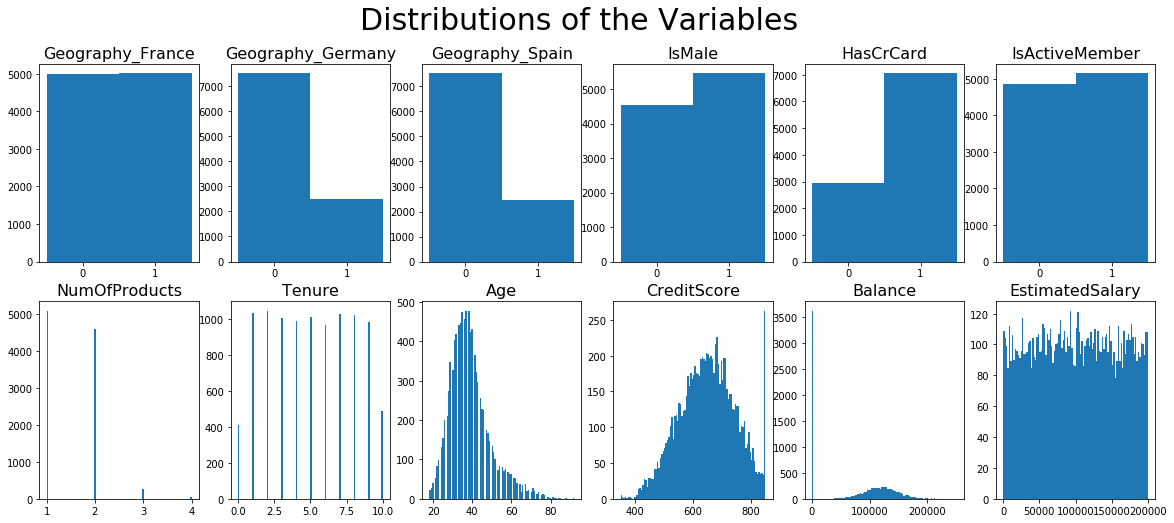

In [3]:
list_binary = [0,1,2,4,9,10]
list_normal = [3,5,6,7,8,11]
order = [0,1,2,4,9,10,8,6,5,3,7,11]

fig=plt.figure(figsize=(20,8))
for i in range(len(order)):
    xi = denorm_bank_data.values[:,order[i]]
    ax1 = fig.add_subplot(2,len(order)/2,i+1)
    plt.title(list(bank_data)[order[i]],fontsize=16)
    if i<6:
        plt.hist(xi,2)
        plt.xticks([0.25,0.75], np.arange(0, 2, 1))
    else:
        plt.hist(xi,100)
plt.suptitle('Distributions of the Variables',fontsize=30)
plt.show()

### 1.2 Valuable Information about Customers

An exploration of the qualitative information that this dataset bears is also essetial. In order to do so, we will plot pie charts, bar plots and box plots of different variables, which will give us some understanding about what differences might be present between customerms.

**How much money has been lost due to customers leaving the institution?**

To put the problem into perspective, we only need to hear a number: **185.588.095€**. That is the total amount of money lost due to the 2037 customers leaving the institution. Almost 200 million €, a daunting number, that more than justifies this work.

In [28]:
lost_savings = denorm_bank_data.loc[bankY['Exited']==1, 'Balance'].sum()
print(lost_savings)

185588094.63


**What is the proportion of customers for each nationality?**

As we may see, more than half of the customers are french, while the other half is almost equally divided between german and spanish customers.

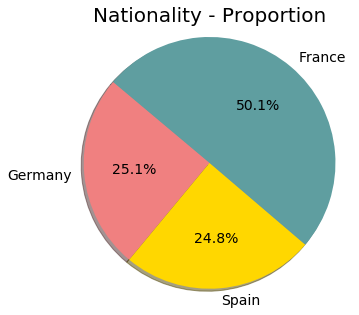

In [36]:
fig=plt.figure(figsize=(5,5))
# First, we will find how many customers each country has
Customers_France = bankX.Geography_France.sum()
Customers_Germany = bankX.Geography_Germany.sum()
Customers_Spain = bankX.Geography_Spain.sum()

# We label, color and plot our data
labels = ['Germany','Spain','France']
sizes = [Customers_Germany, Customers_Spain,Customers_France]
colors = ['lightcoral','gold', 'cadetblue']
plt.title('Nationality - Proportion', fontsize=20)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140,textprops={'fontsize': 14})
plt.axis('equal')
plt.show()

**What is the gender ratio?** 

There is a slightly bigger proportion of accounts owned by men.

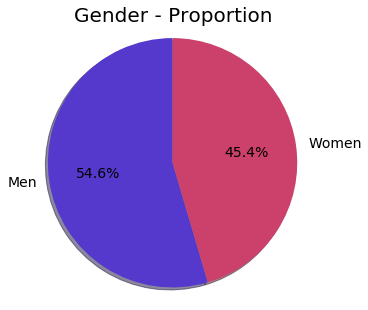

In [37]:
fig=plt.figure(figsize=(5,5))
# Data to plot
Men = bankX.loc[bankX['IsMale']==1, 'IsMale'].count()
Women = bankX.loc[bankX['IsMale']==0, 'IsMale'].count()
labels = ['Men', 'Women']
sizes = [Men,Women]
colors = ['#5539cc','#cb416b']
plt.title('Gender - Proportion', fontsize=20)
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=90,textprops={'fontsize': 14})
plt.axis('equal')
plt.show()

**Is the gender ratio equal for each country?**

There are no surprises in the figure below: for every country the tendency previously shown is followed, and men tend to be the most common owners. In this aspect, Germany is proportionally the most equal country while spanish customers suffer the biggest gap.

*NOTE: The gender ratio (GRatio) is quantitatively calculated by dividing the amount of women by the amount of men. The lower it is, the bigger the propotion of accounts owned by men. GRatio=1 means equity.*

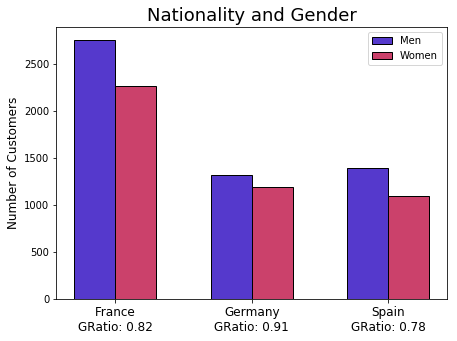

In [38]:
fig=plt.figure(figsize=(7,5))
# Then, for each country we will find all the men
Men = [bankX.loc[bankX['Geography_France']==1, 'IsMale'].sum(), 
       bankX.loc[bankX['Geography_Germany']==1, 'IsMale'].sum(),
       bankX.loc[bankX['Geography_Spain']==1, 'IsMale'].sum()]

# To find the women, we subtract men from total amount of customers
Women = [Customers_France - bankX.loc[bankX['Geography_France']==1, 'IsMale'].sum(), 
         Customers_Germany - bankX.loc[bankX['Geography_Germany']==1, 'IsMale'].sum(),
         Customers_Spain - bankX.loc[bankX['Geography_Spain']==1, 'IsMale'].sum()]
 
# Let's define the width of each bar
barWidth = 0.3

# The x position of bars
r1 = np.arange(len(Men))
r2 = [x + barWidth for x in r1]
 
# Plot men per country
plt.bar(r1, Men, width = barWidth, color = '#5539cc', edgecolor = 'black', label='Men')
# Plot women per country
plt.bar(r2, Women, width = barWidth, color = '#cb416b', edgecolor = 'black', label='Women')
# Ratio
GRatio = [Women[k]/Men[k] for k in range(len(Men))]

# General layout
plt.xticks([r + barWidth/2 for r in range(len(Men))], ['France\nGRatio: ' + str(round(GRatio[0],2)), 'Germany\nGRatio: ' + str(round(GRatio[1],2)), 'Spain\nGRatio: ' + str(round(GRatio[2],2))],fontsize=12)
plt.ylabel('Number of Customers',fontsize=12)
plt.title('Nationality and Gender', fontsize=18)
plt.legend()
 
# Show graphic
plt.show()

**How much do the savings of each country sum up to? Does each gender contribute equally?**

Despite of german customers being half the amount of french ones, they practically add up the same amount of savings. Spanish customers do not follow this tendecy: they preserve a proprotion customers/savings similar to France.

On top of that it is interesting to remark the fact that, since the CRatio is always lower than the GRatio, women have in average a lower account balance than men.

*NOTE: The contribution ratio (CRatio) is quantitatively calculated by dividing the women savings by the men savings. If CRatio=GRatio, men and women contribute equally. If CRatio<GRatio (meaning the ratio women/men savings is lower than women/men no. customers), women contribute less than men.*

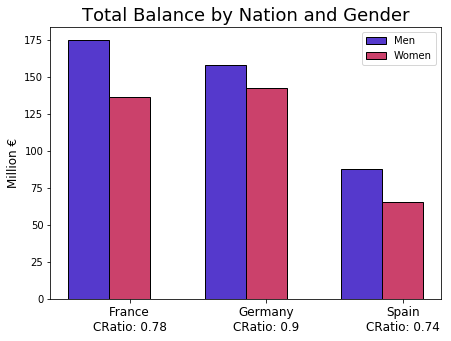

In [33]:
fig=plt.figure(figsize=(7,5))
# Then, for each country we will find all the men
Men = [denorm_bank_data.loc[(bankX['Geography_France']==1) & (bankX['IsMale']==1), 'Balance'].sum()/10**6, 
       denorm_bank_data.loc[(bankX['Geography_Germany']==1) & (bankX['IsMale']==1), 'Balance'].sum()/10**6,
       denorm_bank_data.loc[(bankX['Geography_Spain']==1) & (bankX['IsMale']==1), 'Balance'].sum()/10**6]

# To find the women, we subtract men from total amount of customers
Women = [denorm_bank_data.loc[(bankX['Geography_France']==1) & (bankX['IsMale']==0), 'Balance'].sum()/10**6, 
         denorm_bank_data.loc[(bankX['Geography_Germany']==1) & (bankX['IsMale']==0), 'Balance'].sum()/10**6,
         denorm_bank_data.loc[(bankX['Geography_Spain']==1) & (bankX['IsMale']==0), 'Balance'].sum()/10**6]

# Contribution Ratio
CRatio = [Women[k]/Men[k] for k in range(len(Men))]

# Let's define the width of each bar
barWidth = 0.3

# The x position of bars
r1 = np.arange(len(Men))
r2 = [x + barWidth for x in r1]
 
# Plot men per country
plt.bar(r1, Men, width = barWidth, color = '#5539cc', edgecolor = 'black', label='Men')
# Plot women per country
plt.bar(r2, Women, width = barWidth, color = '#cb416b', edgecolor = 'black', label='Women')
 
# General layout
plt.xticks([r + barWidth for r in range(len(Men))], ['France\nCRatio: ' + str(round(CRatio[0],2)), 'Germany\nCRatio: ' + str(round(CRatio[1],2)), 'Spain\nCRatio: ' + str(round(CRatio[2],2))],fontsize=12)
plt.ylabel('Million €',fontsize=12)
plt.title('Total Balance by Nation and Gender', fontsize=18)
plt.legend()


# Show graphic
plt.show()

**Is there a meaningful gender pay gap?**

Surprisingly, despite of what the GRatio and the CRatio might suggest, there is no significant pay gap. Both genders have the same median, similar (uniform) distributions and a similar maximum salary value, around 200.000€. There are no outliers.

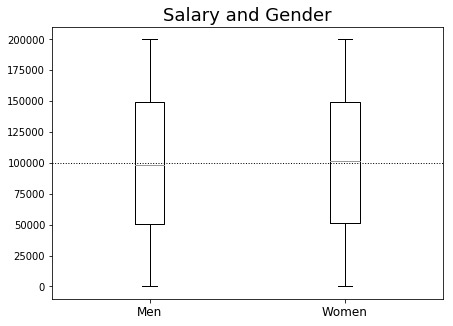

In [28]:
fig=plt.figure(figsize=(7,5))
men_sal = denorm_bank_data.loc[(bankX['IsMale']==1),'EstimatedSalary']
women_sal = denorm_bank_data.loc[(bankX['IsMale']==0),'EstimatedSalary']
Salaries = [men_sal, women_sal]
plt.boxplot(Salaries, positions=[1,2])
plt.plot([0,3],[100000,100000],c='k',lw=1,linestyle=':')
plt.title('Salary and Gender',fontsize=18)
plt.xticks([1,2],['Men','Women'],fontsize=12)
plt.show()

**What is the estimated salary considering now different age ranges?**

Similarly to what happened between genders, for different age ranges there are no significant salary differences. Only for the 74-93 years range we find slight differences, that are most likely produced due to the few customers at that age range (only 54).

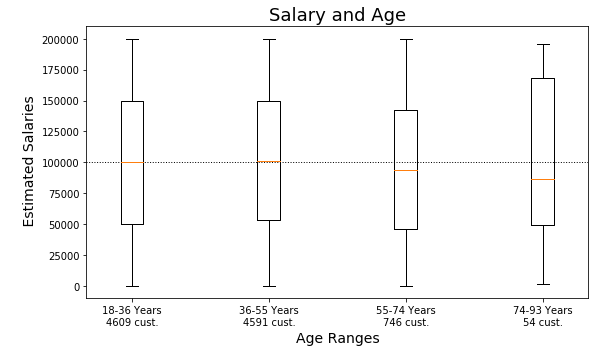

In [30]:
fig=plt.figure(figsize=(9,5))
min_age = denorm_bank_data['Age'].min()
max_age = denorm_bank_data['Age'].max()
num_ranges = 4

steps = np.linspace(min_age,max_age+1,num_ranges+1)
salaries_ranges=[]
number_customers=[]
x_labels=[]
for y in range(len(steps)-1):
    low = steps[y]
    high = steps[y+1]
    salary_y = denorm_bank_data.loc[(denorm_bank_data['Age']>=low) & (denorm_bank_data['Age']<=(high)),'EstimatedSalary']
    number = denorm_bank_data.loc[(denorm_bank_data['Age']>=low) & (denorm_bank_data['Age']<=(high)),'EstimatedSalary'].count()
    salaries_ranges.append(salary_y)
    number_customers.append(number)
plt.boxplot(salaries_ranges, positions = range(1,num_ranges*3,3))
plt.plot([0,20],[100000,100000],c='k',lw=1,linestyle=':')
myticks=[str(int(steps[k])) + '-' + str(int(steps[k+1])) + ' Years\n' + str(number_customers[k]) + ' cust.' for k in range(num_ranges)]
plt.xticks(range(1,num_ranges*3,3),myticks)
plt.xlim(0,num_ranges*3-1)
plt.xlabel('Age Ranges', fontsize=14)
plt.ylabel('\n Estimated Salaries',fontsize=14)
plt.title('Salary and Age',fontsize=18)
plt.show()

### 1.3 Correlation between the Variables

Now that we know a bit more about our customers, let's find the relations between the variables that describe them.

Finding an appropiate measure for the correlation of the variables is not an easy task, since we have to handle both categorical and continuous variables. The main problem comes because the usual Pearson Correlation becomes misleading when the pairs of variables are away from bivariate normality (like it is clearly our case).

Other alternative statistics may be more suitable for this problem, like discretizing all the continuous variables in finite bins and [calculating the mutual information](https://stats.stackexchange.com/questions/29489/how-do-i-study-the-correlation-between-a-continuous-variable-and-a-categorical), which is basically a measure of how good can we predict a distribution knowing another one.

However, since the variables are standarized and the results are still somewhat meaninful (with a cautious interpretation), we will still use the classical correlation matrix.

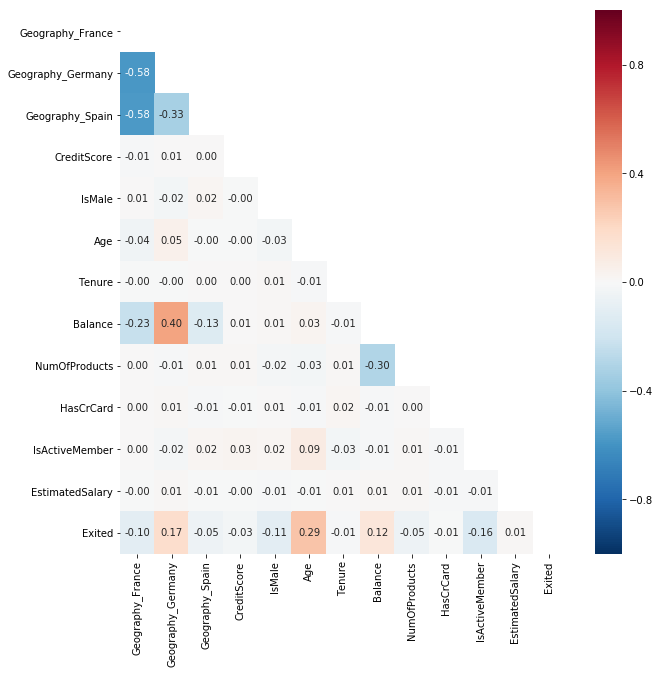

In [42]:
fig=plt.figure(figsize=(10,10))
CX=bank_data.corr()
mask = np.zeros_like(CX, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
heat=sb.heatmap(CX,mask=mask,annot=True, vmin=-1, vmax=1, fmt='.2f',cmap='RdBu_r')
fig.add_subplot(heat)
plt.show()

The results of the correlation matrix only reinforce what we expected from [Section 1.2](#1.2-Valuable-Information-about-Customers). Correlation between variables is pretty low in general (even when the variables that were not studied in the previous section are considered). However, it is important to remark some tendencies seen:
- Being **german** is highly correlated with having a **high account balance**.
- **Germans** are more likely to **leave the bank** than any other nationality.
- **Women** generally **leave** the institution at a higher rate.
- The **churn** (*Exited* variable) is correlated with the **age** and the **account balance**, while negatively correlated with being an **active member**.

## 2. Clustering Customers

The analysis done in the previous section allows us to optimally cluster customers in groups. However, if a typical clustering method like K-Means is used, the problem of categorical variables arises again. Since we have several variables which are maximally separated (dichotomous) in this configuration space, any clustering mechanism based on euclidean distance that we use will tend to cluster based on these categorical variables. A dimension reduction method like PCA is not helpful here either, since it is a method based on finding variables which are linear combination of the original ones, but maximizing the variance (and thus, choosing those dichotomous variables).

Therefore, we need an alternative: either finding another clustering technique, or choosing wisely an appropiate subset of variables. We stick with the latter.

### 2.1 Visualizing the Space of Highly Correlated Variables

If we consider the variables correlated with the churn: **Age**, **Balance** and **IsActiveMember**, not only we overcome the problem of having too many categorical variables, but we will be clustering in a space where location is correlated with the churn. This means that there will probably be clusters with high churn risk, and clusters with lower churn risk. This can be seen in the image below.

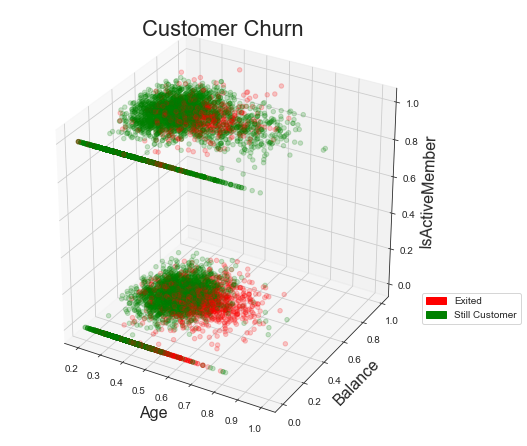

In [44]:
sns.set_style("white")
colors = ["green","red"]
alphas = [0.1,1]
colors = np.array(colors)
alphas = np.array(alphas)
churn = [int(Y[k]) for k in range(len(Y))] 
churn = np.array(churn)

fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
sequence_containing_x_vals = list(range(-1000, 1000))
sequence_containing_y_vals = list(range(-1000, 1000))
sequence_containing_z_vals = list(range(-1000, 1000))

ax.scatter(X[:,5:6], X[:,7:8], X[:,10:11],color=colors[churn], alpha=0.2)
ax.set_xlabel(list(bankX)[5],fontsize=16)
ax.set_ylabel(list(bankX)[7],fontsize=16)
ax.set_zlabel(list(bankX)[10],fontsize=16)
green_patch = mpatches.Patch(color='green', label='Still Customer')
red_patch = mpatches.Patch(color='red', label='Exited')
plt.legend(handles=[red_patch,green_patch],bbox_to_anchor=(1.2,0.35))
plt.title('Customer Churn',fontsize=22)
plt.show()

- Age is of course a discretized variables, but with such a small bin compared to the range of ages possible that no discretization is perceived.
- Balance is continuous.
- IsActiveMember, a dichotomous variable, separates in this space our customers in two diferent regimes: Active (*IsActiveMember=1*) and Inactive members (*IsActiveMember=0*).

*Note: Please, bear in mind that Python plots the thousand of points one after the other, with new points covering the old ones. For this reason, despite of the points being partially transparent, the apparent red and green regions might not correspond to the numerical results of the whole population.*

### 2.2 Finding Clusters

In order to cluster we will use the K-means method. This is an iterative method, where k points (called *centroids*) are generated, and iteration after iteration, they approach to the optimal location of cluster center. Each point receives the label of the closest centroid.

The number of clusters (*k*) needs to be defined. There are several techniques to determine the optimal number, and most of them use the euclidean distance between points or between points and the centroids. Here we will use two methods: Within Cluster Sum of Squares (WCSS) and Silhouette.

In [47]:
# We extract from the complete dataset the columns of interest
dfCorrX = bankX.reindex(['Age', 'Balance','IsActiveMember'], axis=1)
CorrX = dfCorrX.values

**WCSS**

With the name Within Cluster Sum of Squares, the technique is quite self explanatory. Basically we add up for every cluster the distances of its points to the centroid. The more clusters we have, the lower this sum will be. However, it should be noted that the slope in WCSS starts to become *flatter* as we increase the number of clusters. This will be our hint: we need to stop at the number of clusters from which the rate of drop in WCSS doesn't drop substantially anymore.

In [48]:
N=20
elbows=[]

for i in range(2,N):     
  clusterer = KMeans(n_clusters=i).fit(CorrX)
  elbows.append(clusterer.inertia_)

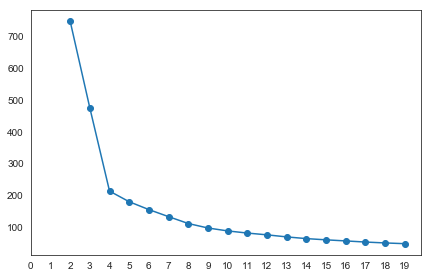

In [61]:
sns.set_style("white")
ax = plt.figure(figsize=(7,4.5)).gca()
ax.plot(range(2,N),elbows, "-o")
ax.set_xticks(range(0,N,1))
plt.show()

It would be immediate to recognize in the figure above k=4 as the optimal number of centroids. In fact, this is quite reasonable, if we take a look at the Figure in [Section 2.1.1](#2.1.1-Visualizing-the-New-Space). The 4 clusters are quite easy to recognize: for inactive members, we have a cluster for account balance zero and nonzero, and the same for active members.

Despite of this result, we will explore other techniques to see if they suggest other interesting possibilities.

**Silhouette**

Silhouette Coefficient is calculated using the mean intra-cluster distance (a) and the mean nearest-cluster distance (b) for each sample. The Silhouette Coefficient for a sample is (b - a) / max(a, b). The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

In [62]:
N=20
sil=[]

for i in range(2,N):    # Warning! error for n_clusters=i=1
  clusterer = KMeans(n_clusters=i).fit(CorrX)
  cluster_labels = clusterer.labels_
  silhouette_avg = silhouette_score(X, cluster_labels)
  sil.append(silhouette_avg)

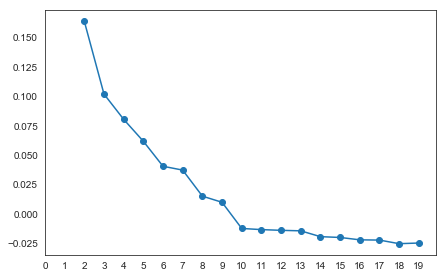

In [63]:
ax = plt.figure(figsize=(7,4.5)).gca()
ax.plot(range(2,N),sil, "-o")
ax.set_xticks(range(0,N,1))
plt.show()

The bigger Silhouette is, the better. However, since the function is monotonically decreasing, the most interesting value occurs for k=6 (slope becomes flatter).

### 2.1.3 Visualizing and Understanding Clusters

We have already clustered our customers. However, we have found several candidates for the predefined number of clusters. The decision of whether taking k=4, k=6 or another value does not only depend on the mathematical arguments here given, but also on the criteria of financial experts and the possible solutions to be applied. 

The function *ClusteringCustomers(k)* is quite flexible, being able to take any value of *k* and preserving always the labelling of the clusters. For each one of the resulting clusters, the function also gives a measure of the churn risk.
_______________________________________________

*Note: Everytime the program runs, random centroids are generated. The model always converges to highly similar locations of cluster centers, but the labels (and hence, the colors in the plot) will be randomly assigned. To solve this issue, we have come up with an artifact:*

*The sum of the dimensions for each centroid is calculated. This will give a list of values, as many as centroids, which for small k we assume different enough. Everytime the program runs, this list of values is sorted by size. In such a way, the labels of each cluster do not depend on the random initialization. We just perform a change of labels, based on the sorted labelling of clusters.*

In [17]:
def ClusteringCustomers(k):
    sns.set_style("white")
    clusters = KMeans(n_clusters=k).fit(CorrX)
    initial_labelled=clusters.labels_

########################################### Change of Labels #############################################
    # Old Label Basis
    basis_sum_original = clusters.cluster_centers_.sum(axis=1)
    # New Label Basis
    basis_sum_control = sorted(basis_sum_original)
    # Label Basis Transformation
    final_labelled = [basis_sum_control.index(k) for k in basis_sum_original[initial_labelled]]
##########################################################################################################
    
    # Plotting histogram of number of customers per cluster
    plt.figure()
    plt.title('Number of Customers per Cluster', fontsize=20)
    plt.hist(final_labelled,bins=range(k+1))
    plt.xticks(np.arange(0.5,k), np.arange(1, k+1, 1))
    plt.show()
    
    # Plotting actual 3D plot of the customers
    fig = plt.figure(figsize=(6,6))
    ax = Axes3D(fig)
    sequence_containing_x_vals = list(range(-1000, 1000))
    sequence_containing_y_vals = list(range(-1000, 1000))
    sequence_containing_z_vals = list(range(-1000, 1000))

    colors = np.array(["#033500", "#840000", "blue", "orange", 'purple', "#363737"])
    ax.scatter(CorrX[:,0], CorrX[:,1], CorrX[:,2],color=colors[final_labelled],s=20, depthshade=True, alpha=0.2)
    plt.title('Clusters of Customers - k = '+str(k),fontsize=20)
    ax.set_xlabel(list(dfCorrX)[0],fontsize=16)
    ax.set_ylabel(list(dfCorrX)[1],fontsize=16)
    ax.set_zlabel(list(dfCorrX)[2],fontsize=16)

    patches = []
    for i in range(k):
        patch = mpatches.Patch(color=colors[i], label='Cluster '+str(i))
        patches.append(patch)
    ax.legend(handles=patches,bbox_to_anchor=(1.15,0.35))
    plt.show()
    
    # Now we will predict the risk of each cluster. However, recall that in total 7963 of them remained and only 2037 exited
    # We will consider a Risk=1 (maximum) if the 2037 cases of exited clients occur in the same cluster.
    
    for p in range(k):
        ClusterExited = int(bankY[[i==p for i in final_labelled]].sum())
        TotalExited = int(bankY.sum())
        ClusterRisk = ClusterExited / TotalExited
        print('The risk ratio of Cluster',p,'is',round(ClusterRisk*100,1),'%')
        
    return

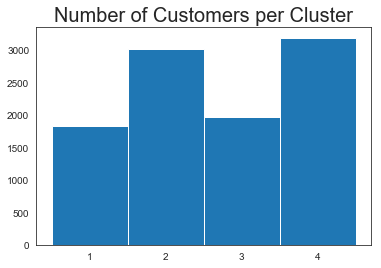

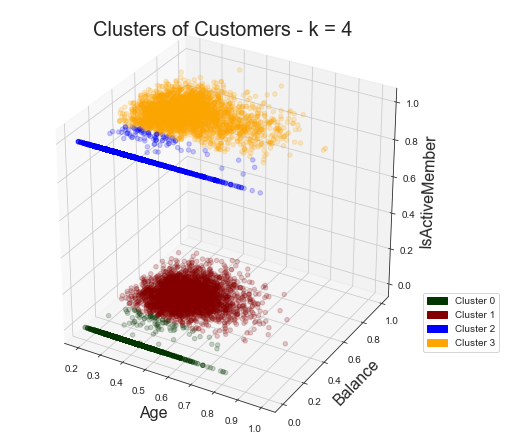

The risk ratio of Cluster 0 is 17.2 %
The risk ratio of Cluster 1 is 46.7 %
The risk ratio of Cluster 2 is 9.6 %
The risk ratio of Cluster 3 is 26.5 %


In [18]:
ClusteringCustomers(k=4)

As we can see, for k=4 the obvious clusters are formed. Interestingly, Cluster 1, with people of all ages classified by the institution as inactive and with account balance non-zero, bears almost 50% of the risk ratio! Further study for other k-values (like the cited k=6) might give finer results, and together with other techniques, the origin of this churn can be understood and solutions applied accordingly.

## 3. How to Handle Imbalanced Classes

The number of samples belonging to the class 'Exited = 1' (2037) is significantly lower than those belonging to the class 'Exited = 0' (7963). In this situation, model training with these data could lead to inaccurate predictions. In order to obtain the same number of instances for both classes, several techniques present in [imbalanced-learn API](https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling) have been used, in such a way that we finally choose the best one. These strategies are divided in **oversampling** techniques (create more instances of the minority class), **undersampling** techniques (reduce the number of instances of the majority class), and the combination between **undersampling + oversampling**.

**Undersampling**: *ClusterCentroids*: Equals to **2037** the number of instances of both classes.

**Oversampling**: *SMOTENC*: Equals to **7963** the number of instances of both classes, *ADASYN*: Increases to **8600** the number of instances of the minority class 'Exited = 1'.

**Undersampling** + **Oversampling**: *SMOTEENN*: Decreases to **5041** the number of instances of the majority class 'Exited = 0' and increases to **6678** the number of instances of the minority class 'Exited = 1'.

# 4. Neural network models

Initially, we have carried out several experimental tests with which we have established a suitable architecture of the **Multi-Layer Perceptron** for solving the binary classification problem addressed. *Dropout* and *Batch Normalization* regularization techniques are used, as well as *Adam* optimization algorithm for updating network weights. This architecture is common for each resample strategy, as the model is sepparately trained with each resampled dataset, in such a way we can compare the performance of each resample technique.

First of all, we import the necessary libraries and create the validation partition (*X_val*, *Y_val*). To compare each resampling technique, this validation partition must be the same when validating each model. **It is important to always test on the original (imbalanced) distribution**. In addition, we declare the number of times each model will be trained (*iterations*), so that we can draw conclusions minimizing the effects of randomness produced in the training:

In [3]:
from tensorflow.keras.layers     import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils      import to_categorical
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint

  # Common X_val and Y_val for validating the classifiers
X_train, X_val, Y_train, Y_val = train_test_split(X, Y.ravel(), test_size=0.3)

iterations = 2  # Times that each model is going to be trained, in order to compare them with each other

## 4.1 Training the model with imbalanced data

So, the first step is to train the model with the original (imbalanced) data, although later we validate all models with the common validation set defined above.


**Imbalanced data:**  **7963** '0' labels and **2037** '1' labels.

Iteration Nº 0 : 

Accuracy training with imbalanced data (default threshold=0.5): 93.133333 %


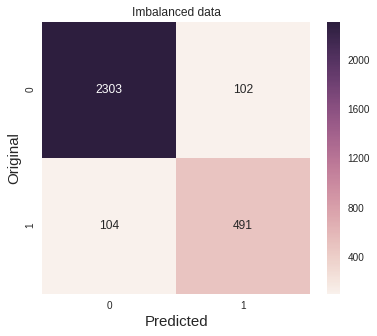

Iteration Nº 1 : 

Accuracy training with imbalanced data (default threshold=0.5): 92.333333 %


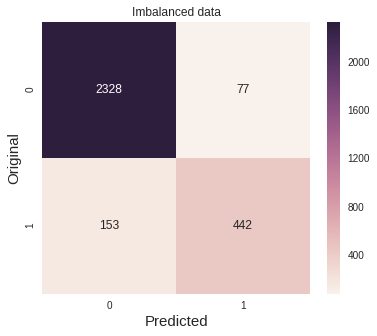

In [0]:
origDataModel = []  # will contain the #iterations models trained with the original (imbalanced) data

for i in range(iterations):
  
  print("Iteration Nº", i, ": \n")

  X_train, X_test, Y_train, Y_test = train_test_split(X, Y.ravel(), test_size=0.3)

  model = tf.keras.Sequential()

  model.add(Dense(256, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(128,  activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(32, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(8,  activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Dense(1, activation='sigmoid'))

  model.compile(optimizer=tf.train.AdamOptimizer(),
                loss='binary_crossentropy',
                metrics=['acc'])

  model_logs = model.fit(X_train,
          Y_train,
          batch_size=32,
          epochs=120,
          verbose=0,  # silent mode
          validation_data=(X_test, Y_test))  # Only to check that the model is not "overfitting" the training data
  
  origDataModel.append(model)

    # Pseudo-validate with common validation data

  score = model.evaluate(X_val, Y_val, verbose=0)  # tensorflow default threshold = 0.5
  print("Accuracy training with imbalanced data (default threshold=0.5): {:-5f} %".format(score[1] * 100))

  Y_pred = model.predict(X_val) > 0.5  # manual threshold
  matConf = confusion_matrix(Y_val, Y_pred)
  valsize = Y_val.shape[0]

  plt.figure(figsize=(6, 5))  # Establishing the heatmap size before plotting
  ax = sb.heatmap(matConf, annot=True, fmt=".0f")
  ax.set_ylabel('Original', fontsize=15)
  ax.set_xlabel('Predicted', fontsize=15)
  plt.title("Imbalanced data")
  plt.show()

The figures above show the prediction of the 2 models trained with the original (imbalanced) data by means of a **confusion matrix**, taking as threshold in the classification the default value of tensorflow *accuracy classification threshold*: 0.5. In the following sections we will discuss the appropriateness of choosing this threshold value.

## 4.2 Data resampling and model training with new data

Then, we proceed to train each **Multi-Layer Perceptron** with a different set of resampled data. Logically, each set is calculated before training, following a certain resampling strategy from those defined previously. For this series of trainings we use two nested loops. The first loop is used to carry out #*iterations* trainings with each technique and show a comparison of the confusion matrices. In the second loop, for each iteration we instantiate each resampling technique and train the model with this data:

Iteration Nº 0 : 

After ClusterCentroids : 
X.shape: (4074, 12), Y.shape: (4074, 1)
[2037] '0' labels, [2037] '1' labels
Accuracy training with resampled data (default threshold=0.5): 78.600000 %

After SMOTENC : 
X.shape: (15926, 12), Y.shape: (15926, 1)
[7963] '0' labels, [7963] '1' labels
Accuracy training with resampled data (default threshold=0.5): 93.300000 %

After ADASYN : 
X.shape: (16563, 12), Y.shape: (16563, 1)
[7963] '0' labels, [8600] '1' labels
Accuracy training with resampled data (default threshold=0.5): 94.566667 %

After SMOTEENN : 
X.shape: (11687, 12), Y.shape: (11687, 1)
[5046] '0' labels, [6641] '1' labels
Accuracy training with resampled data (default threshold=0.5): 82.700000 %



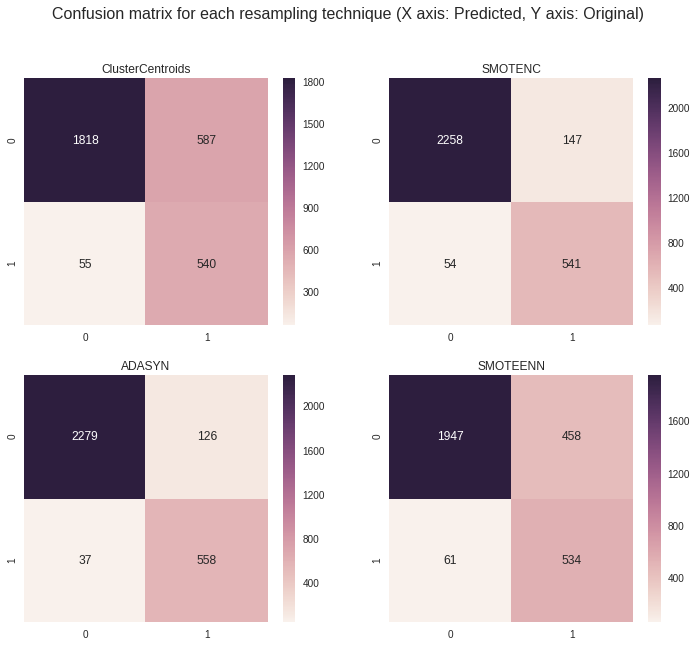

Iteration Nº 1 : 

After ClusterCentroids : 
X.shape: (4074, 12), Y.shape: (4074, 1)
[2037] '0' labels, [2037] '1' labels
Accuracy training with resampled data (default threshold=0.5): 73.866667 %

After SMOTENC : 
X.shape: (15926, 12), Y.shape: (15926, 1)
[7963] '0' labels, [7963] '1' labels
Accuracy training with resampled data (default threshold=0.5): 92.800000 %

After ADASYN : 
X.shape: (16563, 12), Y.shape: (16563, 1)
[7963] '0' labels, [8600] '1' labels
Accuracy training with resampled data (default threshold=0.5): 93.733333 %

After SMOTEENN : 
X.shape: (11758, 12), Y.shape: (11758, 1)
[5053] '0' labels, [6705] '1' labels
Accuracy training with resampled data (default threshold=0.5): 78.333333 %



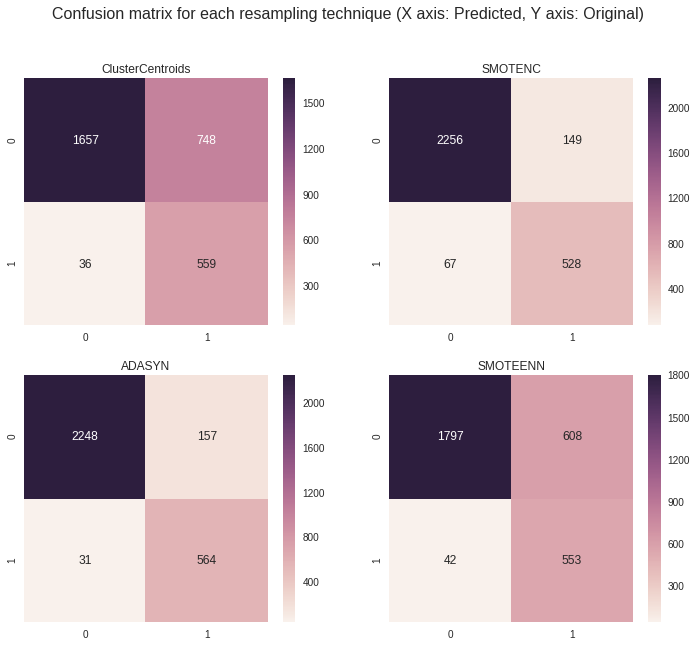

In [0]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTENC, ADASYN
from imblearn.combine import SMOTEENN

li = [ClusterCentroids, SMOTENC, ADASYN, SMOTEENN]  # List of resampling techniques
li_names = ["ClusterCentroids", "SMOTENC", "ADASYN", "SMOTEENN"]  # List of their names (with visualization purposes)
models = []  # list that will contain the 4 models, x2 iterations, trained with resampled data

cat_index = [0, 1, 2, 4, 9, 10]  # List of categorical features indexes (only used in SMOTENC)

for i in range(iterations):
  
  print("Iteration Nº", i, ": \n")

  plt.figure(figsize=(12, 10))  # Establishing the heatmap size before plotting
  plt.suptitle("Confusion matrix for each resampling technique (X axis: Predicted, Y axis: Original)", fontsize=16)

  for n, method in enumerate(li):

    if(method==SMOTENC):  # An instance of the resampling technique
      resampler = method(cat_index) 
    else: resampler = method()

    X_resampled, Y_resampled = resampler.fit_resample(X, Y.ravel())  # Resampled sets
    Y_resampled = Y_resampled[:, np.newaxis]

    print("After", li_names[n], ": \nX.shape: {}, Y.shape: {}".format(X_resampled.shape, Y_resampled.shape))
    print("{} '0' labels, {} '1' labels".format(sum(Y_resampled==0), sum(Y_resampled==1)))

    # After resampling, we shuffle to avoid data pools with the same label
    # In this way, even more large fluctuations in accuracy value could be avoided

    data_resampled = np.hstack((X_resampled, Y_resampled))
    np.random.shuffle(data_resampled)
    X_resampled = data_resampled[:,:12]
    Y_resampled = data_resampled[:,12:13]

    X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled.ravel(), test_size=0.3)

    # Neural network model

    modelresampled = tf.keras.Sequential()

    modelresampled.add(Dense(256, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(128,  activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(64, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(32, activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(8,  activation='relu'))
    modelresampled.add(BatchNormalization())
    modelresampled.add(Dropout(0.3))

    modelresampled.add(Dense(1, activation='sigmoid'))

    modelresampled.compile(optimizer=tf.train.AdamOptimizer(),
                  loss='binary_crossentropy',
                  metrics=['acc'])

    modelresampled_logs = modelresampled.fit(X_train,
            Y_train,
            batch_size=32,
            epochs=120,
            verbose=0,  # silent mode
            validation_data=(X_test, Y_test))  # Only to check that the model is not "overfitting" the training data

    models.append(modelresampled)

    # Pseudo-validate with common validation data

    score = modelresampled.evaluate(X_val, Y_val, verbose=0)  # tensorflow default threshold = 0.5
    print("Accuracy training with resampled data (default threshold=0.5): {:-5f} %\n".format(score[1] * 100))
    Y_pred = modelresampled.predict(X_val) > 0.5
    matConf = confusion_matrix(Y_val, Y_pred)
    valsize = Y_val.shape[0]

    ax = plt.subplot(2, 2, n+1)
    ax.set_title(li_names[n])
    ax = sb.heatmap(matConf, annot=True, fmt=".0f")

  plt.show()

At this point, we can compare the confusion matrix of each model. But, can we really draw any conclusions using these metrics? The model trained with the imbalanced data set achieves an accuracy of more than 93%. But, does this indicate that this model performs similarly to the model trained with SMOTENC, which achieves an accuracy of around 93%? The answer is **NO, there can be a great quality difference between models with similar accuracies. We can't rely on accuracy**.

# 5. Beyond accuracy metric: Receiver Operator Characteristic (ROC) Curve

As [Tom Fawcett](http://www.svds.com/learning-imbalanced-classes/) states, **You can only make progress if you’re measuring the right thing**. In other words, **don’t use accuracy to evaluate your classifier!**

There are two major problems. Accuracy applies a **naive threshold of 0.50** to decide between classes, and this is often wrong when classes are imbalanced. Secondly, the clasification accuracy is based on a simple counting of errors, and we need to know more than that. We want to know which classes are getting confused and where. Evaluating a model using accuracy would favor classifiers that always predict a negative outcome for rare events (considering positive events the less frequent ones, like in our case). In this context, accuracy, and even the confusion matrix, are not enough since they both assume naive threshold. Therefore, we should visualize classifier performance using other metrics, such as the **ROC Curve**.

A **Receiver Operator Characteristic (ROC) Curve** is a graphical plot used to show the diagnostic ability of binary classifiers [(Carmen Chan)](https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/): A **ROC Curve** is constructed by plotting the true positive rate (**TPR**) against the false positive rate (**FPR**). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (**TP**/(**TP** + **FN**)). Similarly, the false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (**FP**/(**TN** + **FP**)).

In order to let the model trained with the original data take part in this comparison, we add it to the list containing the models for both *iterations*, and update the list of names of the resampling strategies:

In [0]:
  # List containing in which position has the model trained with original data to be inserted in models list
  
lst_insert = [x for x in range(0, iterations*(len(li_names)+1)) if x % (len(li_names)+1) == 0]

for ie, e in enumerate(lst_insert): models.insert(e, origDataModel[ie])
  
li_names.insert(0, "Original data")  # Placing Original data at the beginning

At this point, having a reference to memory of all trained models, it is possible to compare their performance by **plotting their ROC Curve**. To do this, we will iterate along the models a total of *iterations* times, and in each iteration the ROC Curve for each model will be shown. ***Sklearn.metrics.roc_curve*** allows to compute the ROC, returning the **FPR**, the **TPR** and the **threshold** relative to the two previous values. In this way, we get the FPR and the TPR for a wide list of classifier threshold values between 0 and 1. One approach to state the performance of each classifier into a single measure is to calculate the **area under the ROC Curve** (**AUC**). Importing ***sklearn.metrics.auc***, it is possible to calculate the AUC given a FPR and a TPR. 0 <= AUC <= 1 can be defined as the probability that a randomly chosen 'Exited = 1' instance is ranked higher than a randomly chosen 'Exited = 0' instance.

![AUC](https://cdn-images-1.medium.com/max/1000/1*AgDJbm6d8qr8ESHNv6VvKg.png) ![AUC](https://cdn-images-1.medium.com/max/1000/1*KNhNw8BsjbIETPF_BH8Qpg.png)

As we see in the figures [(Jocelyn D'Souza)](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152), where the blue curves represent different **ROC Curves**, the first model does a good job in classifying values between positive and negative. Therefore, the **AUC** score is 0.9 as the area under the **ROC Curve** is large. Whereas, the predictions performed by the last model are completely overlapping each other, as the classifier is performing poorly and it classificates almost randomly, so the **AUC** is almost equal to 0.5.

So, by putting all these metrics together, it is possible to draw conclusions for each model:

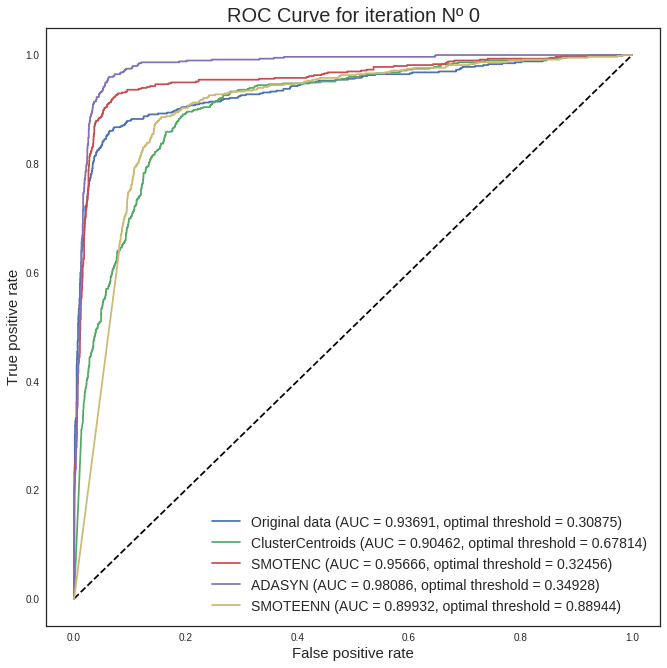

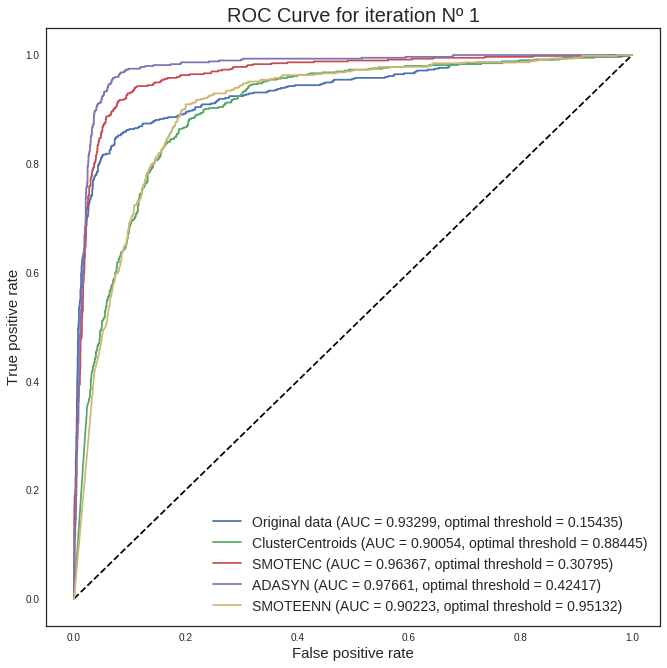

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

for i in range(iterations):

  plt.figure(i+1, figsize=(11, 11))
  plt.title('ROC Curve for iteration Nº '+str(i), fontsize=20)
  plt.xlabel('False positive rate', fontsize=15)
  plt.ylabel('True positive rate', fontsize=15)
  plt.plot([0, 1], [0, 1], '--', color='black')

  for j in range(len(li_names)):  # For each model, calculate false positive rate, true positive rate and area under curve
    pred = models[len(li_names)*i+j].predict(X_val).ravel()  # Predictions for each model
    fpr, tpr, thresholds = roc_curve(Y_val, pred)  # False positive rate, true positive rate, threshold
    auc_ = auc(fpr, tpr)

    opt_index = np.argmax(np.abs(tpr-fpr))  # Optimal threshold: point where tpr is high and fpr is low
    opt_threshold = thresholds[opt_index]
    
    plt.plot(fpr, tpr, label=li_names[j]+' (AUC = {:.5f}, optimal threshold = {:.5f})'.format(auc_, opt_threshold))
    
  plt.legend(loc='lower right', prop={'size': 14})  # Display the legend
  plt.show()

The **ROC Curves** shown above reflect the trade-off between *sensitivity* (or **TPR**, often called *recall*, that measures how good a test is at detecting the positives) and *inverted specificity* (**FPR**, being *specificity* = 1 - **FPR**) for each model trained with different resampled data. *Specifity* determines how good a test is at avoiding false positives. As a baseline, a random classifier is expected to give points lying along the diagonal (**FPR** = **TPR**). The closer the curve comes to the 45-degree diagonal of the **ROC** space, the less accurate the test. In the other hand, classifiers whose **ROC Curve** is closer to the top-left corner indicate a better performance. 

Thus, in view of the results provide by both plots, it can be established that the most suitable resampling technique is *ADASYN*, which stands out from the other resampling techniques, due to the high value of its AUC (close to 1). As it can be seen, the model trained with *ADASYN* resampling outperforms the model trained with original, imbalanced data. The **ROC Curve** has also allowed us to determine that the optimum threshold value for the classifier resampled with ADASYN is approximately 0.35 in the first iteration and 0.425 in the second one.

To conclude, the experimental results have indicated that, for this dataset, it is suitable to perform **Oversampling** based on *ADASYN* to balance the classes and train the classifier. As a future task, the efficiency of this classifier can be demonstrated training a model with an optimal threshold value in the range (0.35, 0.425), and evaluating the quality of the predictions made.

